In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

from sklearn.metrics import roc_auc_score

import itertools

%matplotlib inline

In [2]:
train  = pd.read_csv('train_tweets.csv',delimiter=';')
test = pd.read_csv('test_tweets.csv',delimiter=';')

In [3]:
#Vamos verificar as primeiras linhas do conjunto de dados de treinamento
train.head()

,id,tweet,label
0,1,RT @_makavelijones: Bolsonaro estÃ¡ chamando n...,1
1,2,Siza Vieira Ã© casado com dirigente da associa...,1
2,3,"RT @PNoviello: Analfabetismo em 1970: 33,6% Em...",1
3,4,RT @jcaleluia: NÃ£o Ã© de hoje que denuncio o ...,1
4,5,RT @monicaodovale: O primeiro que votou no Bol...,0


In [4]:
test.head()

,id,tweet,label
0,1,"RT @GuilhermeBoulos: Bolsonaro disse ""não ter ...",1
1,2,@jairbolsonaro @JssicaM54893849 Eu voto Bolson...,1
2,3,"RT @fafadjibelem: IMPORTANTE — Era óbvio, mas ...",1
3,4,RT @g1politica: Haddad participa com advogados...,1
4,5,RT @Marcelodedois: Alguém sabe citar o nome de...,1


In [5]:
# combinando/ "juntando" o conjunto de dados do treinamento com o conjunto de testes
junt = test.append(train, ignore_index=True)

In [6]:
# função para remover o padrão '@user' de todos os tweets dos dados.
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt   

In [7]:
# Criação de uma nova coluna chamada tweet_limpo, ela conterá os tweets limpos e processados. 
#“@ [\ w] *” Expressão regular que pegar tudo que comece com @
# remove twitter handles (@user)
junt['tweet_limpo'] = np.vectorize(remove_pattern)(junt['tweet'], "@[\w]*")


In [8]:
junt['tweet_limpo']

0     RT : Bolsonaro disse "não ter controle" de emp...
1                      Eu voto Bolsonaro 17 com orgulho
2     RT : IMPORTANTE — Era óbvio, mas a Folha de Sã...
3     RT : Haddad participa com advogados e juristas...
4     RT : Alguém sabe citar o nome de um grande esc...
5     RT : Se apoio espontâneo de brasileiros for ca...
6     Nova cirurgia de Bolsonaro deve ser realizada ...
7     RT : ⚡️ Segundo reportagem da , empresários es...
8     RT : Estamos diante de uma tentativa de fraude...
9     RT : O Bolsonaro já mandou a polícia militar d...
10    RT : Bolsonaro faz campanha arbitrária no BOPE...
11    RT : Huahauahahahahah olha o ex-mensalinho do ...
12    RT : Diretor do Datafolha diz que fake news de...
13    vixeeee.. o PT faz de tudo pelo o poder. #Caix...
14    RT : É muito conveniente pro PT atacar o Bolso...
15    RT : A Folha de S. Paulo não tem nenhuma credi...
16    RT : https://t.co/3F9NwxZFwS PARA PAGAR FAKE N...
17    Descoberta "piranha" de água salgada com 1

In [9]:
#Aqui vamos substituir tudo, exceto caracteres e hashtags com espaços.
# remover caracteres especiais, números, pontuações
junt [ 'tweet_limpo' ] = junt [ 'tweet_limpo' ] .str.replace ( "[^ a-zA-Z #]" , "" ) 

In [10]:
# remover todas as palavras com comprimento igual ou inferior a 3
junt['tweet_limpo'] = junt['tweet_limpo'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [11]:
junt.head()

,id,tweet,label,tweet_limpo
0,1,"RT @GuilhermeBoulos: Bolsonaro disse ""não ter ...",1,Bolsonaro disse controle empresrio simptico co...
1,2,@jairbolsonaro @JssicaM54893849 Eu voto Bolson...,1,voto Bolsonaro orgulho
2,3,"RT @fafadjibelem: IMPORTANTE — Era óbvio, mas ...",1,IMPORTANTE bvio Folha Paulo apurou campanha di...
3,4,RT @g1politica: Haddad participa com advogados...,1,Haddad participa advogados juristas encontro d...
4,5,RT @Marcelodedois: Alguém sabe citar o nome de...,1,Algum sabe citar nome grande escritor filsofo ...


In [12]:
# dividindo uma cadeia de texto em tokens,ou seja, palavra ou termo
tokenized_tweet = junt['tweet_limpo'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Bolsonaro, disse, controle, empresrio, simpti...
1                           [voto, Bolsonaro, orgulho]
2    [IMPORTANTE, bvio, Folha, Paulo, apurou, campa...
3    [Haddad, participa, advogados, juristas, encon...
4    [Algum, sabe, citar, nome, grande, escritor, f...
Name: tweet_limpo, dtype: object

In [13]:
#Stemming é um processo baseado em regras de remover os sufixos (“ing”, “ly”, “es”, “s” etc.) de uma palavra. 
#Por exemplo, Por exemplo - “play”, “player”, “play”, “plays” e “playing” são as diferentes variações da palavra - “play”.
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [bolsonaro, diss, control, empresrio, simptico...
1                           [voto, bolsonaro, orgulho]
2    [important, bvio, folha, paulo, apur, campanha...
3    [haddad, participa, advogado, jurista, encontr...
4    [algum, sabe, citar, nome, grand, escritor, fi...
Name: tweet_limpo, dtype: object

In [14]:
# Juntar os tokens novamente
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

junt['tweet_limpo'] = tokenized_tweet

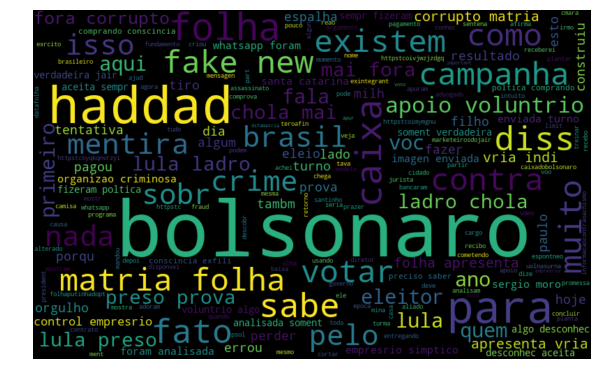

In [15]:
# 3. Geração e Visualização de Histórias de Tweets
# visualizando todas as palavras de nossos dados usando o gráfico wordcloud.
all_words = ' '.join([text for text in junt['tweet_limpo']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

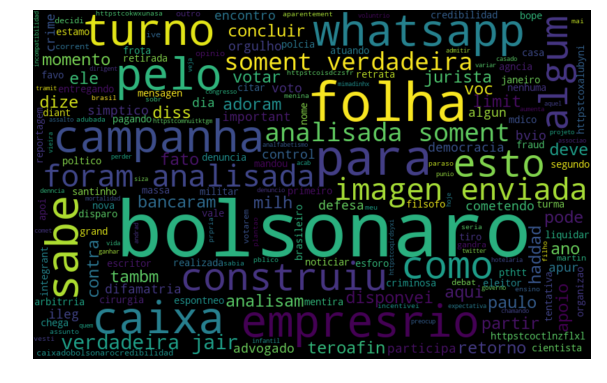

In [16]:
#Palavras em tweets Positivos
# o label 'positivo' denota que o tweet é positivo
normal_words =' '.join([text for text in junt['tweet_limpo'][junt['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

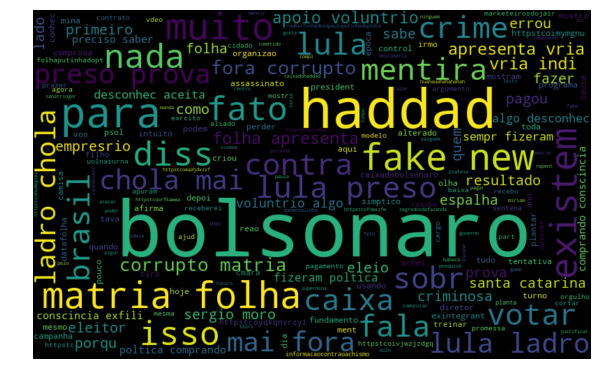

In [17]:
#Palavras em tweets Negativo
# o label 'Negativo' denota que o tweet é Negativo
negative_words = ' '.join([text for text in junt['tweet_limpo'][junt['label'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [18]:
#Armazenaremos todos os termos de tendência em duas listas separadas - uma para tweets positivos
# e outra para tweets negativos.
# função para coletar hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop sobre as palavras no tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [19]:
# extraindo hashtags de tweets positivos
HT_regular = hashtag_extract(junt['tweet_limpo'][junt['label'] == 1])

# extraindo hashtags de tweets negativos
HT_negative = hashtag_extract(junt['tweet_limpo'][junt['label'] == 0])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

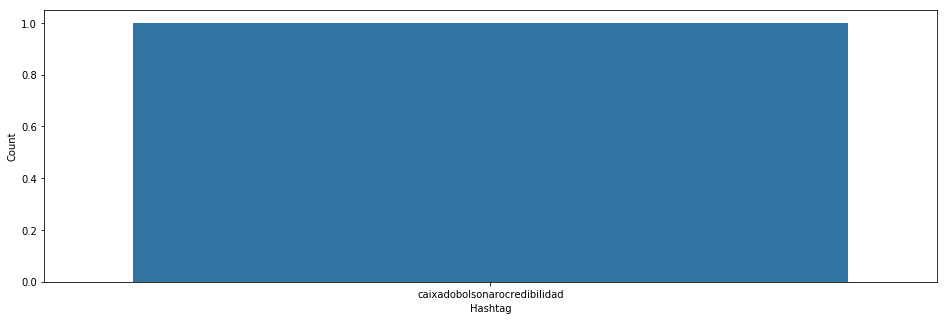

In [20]:
# hashtag Tweets Positivos
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecionando as 10 principais hashtags mais frequentes    
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

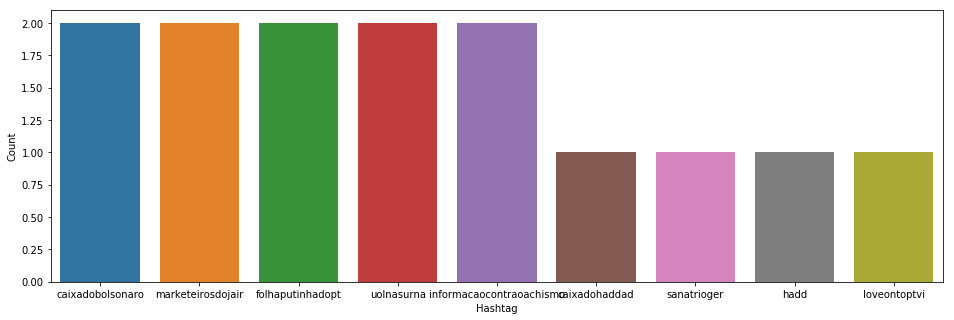

In [21]:
# hashtag Tweets Negativo
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecionando as 10 principais hashtags mais frequentes  
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [22]:
#Extraçao de recursos tweet limpos utilizando Recursos do Bag-of-Words
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words matriz de sentimentos
X_train = junt['tweet_limpo'][:70]
bow = bow_vectorizer.fit_transform(X_train)

Y_train = junt['label'][:70]
print(len(X_train))

X_test = junt['tweet_limpo'][70:]
bow_test = bow_vectorizer.transform(X_test)
Y_test = junt['label'][70:]
print(len(X_test))
# vetor_teste = bow_vectorizer.transform(X_teste)
Y_train

70
30


0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    0
12    0
13    0
14    0
15    1
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
     ..
40    0
41    0
42    0
43    0
44    1
45    0
46    0
47    1
48    1
49    1
50    1
51    0
52    1
53    1
54    0
55    0
56    0
57    0
58    0
59    0
60    1
61    0
62    1
63    1
64    0
65    0
66    0
67    0
68    0
69    0
Name: label, Length: 70, dtype: int64

In [23]:
type(bow)

scipy.sparse.csr.csr_matrix

In [24]:
bow.todense()[0]

matrix([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
         0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]], dtype=int64)

In [25]:
# Recursos do TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000)
# TF-IDF matriz de sentimentos
tfidf = tfidf_vectorizer.fit_transform(junt['tweet_limpo'])

In [26]:
# Model Building: Análise de Sentimento
# Modelo de construção usando recursos do Bag-of-Words
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

vp = 0
fn = 0
fp = 0
vn = 0

lreg = LogisticRegression()
lreg.fit(bow, Y_train) # training the model
Y_predi = lreg.predict(bow_test)
prediction = lreg.predict_proba(bow_test) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

for i in range(len(Y_test)):
    accuracy_score(Y_test, Y_predi) # calculating f1 score
    

    if (Y_train[i]==1 and Y_predi[i]==1):
           vp = vp + 1
    if (Y_train[i] == 0 and Y_predi[i] == 0):
        vn = vn + 1    
    if (Y_train[i] == 1 and Y_predi[i] == 0):
         fn = fn + 1  
    if (Y_train[i] == 0 and Y_predi[i] == 1):
         fp = fp + 1
        
print('Acuracia:',accuracy_score(Y_test, Y_predi))        
print('Verdadeiro positivo:', vp, '- "O que eu falei que era positivo o algoritmo entendeu como positivo".')
print('Verdadeiro Negativo:', vn, '- "O que eu falei que era negativo o algoritmo entendeu como negativo".')
print('Falso Negativo:', fn, '- "O que eu falei que era positivo o algoritmo entendeu como negativo".')
print('Falso Positivo:', fp, '- "O que eu falei que era negativo o algoritmo entendeu como positivo".')

Acuracia: 0.7333333333333333
Verdadeiro positivo: 2 - "O que eu falei que era positivo o algoritmo entendeu como positivo".
Verdadeiro Negativo: 16 - "O que eu falei que era negativo o algoritmo entendeu como negativo".
Falso Negativo: 10 - "O que eu falei que era positivo o algoritmo entendeu como negativo".
Falso Positivo: 2 - "O que eu falei que era negativo o algoritmo entendeu como positivo".


In [27]:
# Acuracia = Verdadeiro Positivo + Verdadeiro Negativo/ Total
Acuracia = 0
Acuracia = ((vp + vn)/20)
print(Acuracia)

0.9


In [28]:
# Precisao = Verdadeiro Positivo/ Verdadeiro Positivo + Falso Positivo
Precisao = 0
Precisao = (vp /(vp + fp))
print(Precisao)

0.5


In [29]:
# Recall = Verdadeiro Positivo/ Verdadeiro Positivo + Falso Negativo
Recall = 0
Recall = (vp/(vp + fn))
print(Recall)

0.16666666666666666


In [30]:
# F1 Score = 2 * Precisao * Recall/ Precisao + Recall
F1 = 0
F1 = ((2 * Precisao * Recall)/(Precisao + Recall))
print(F1)

0.25


In [31]:
predicao_lreg = lreg.predict(bow)

In [32]:
# Funcao de Matriz de Confusao
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        None
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
#Model: Treinando o modelo

# Importa Modelo
lNB = MultinomialNB()

# Treina o modelo
lNB.fit(bow, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

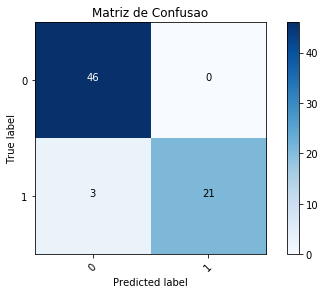

In [34]:
# Matrix de Confusão treino
cnf_matrix = confusion_matrix(Y_train, predicao_lreg)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lreg.classes_,
                      title='Matriz de Confusao')


In [35]:
#Evaluation: Testando o Modelo
# Transoforma dados de Teste
predicao_NB = lNB.predict(bow_test)

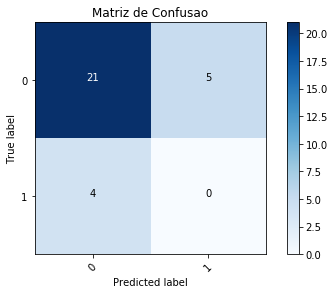

In [36]:
# Matrix de Confusão Teste
cnf_matrix = confusion_matrix(Y_test, predicao_NB)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lreg.classes_,
                      title='Matriz de Confusao')

In [37]:
random_state = np.random.RandomState(0)

In [38]:


y_score = lreg.fit(bow, Y_train).decision_function(bow_test)
#y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [39]:
y_score.shape

(30,)

In [40]:
#fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_score, pos_label=2)

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [41]:
fpr

array([0.  , 0.03, 0.2 , 0.37, 0.4 , 0.47, 0.57, 0.67, 0.73, 0.83, 0.9 ,
       1.  ])

In [42]:
tpr

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [43]:
thresholds

array([ 1.53,  0.53, -0.07, -0.54, -0.55, -0.63, -0.74, -0.91, -0.99,
       -1.2 , -1.31, -2.64])

In [44]:
Y_test

70    1
71    1
72    1
73    1
74    0
75    0
76    0
77    0
78    0
79    0
80    0
81    0
82    0
83    0
84    0
85    0
86    0
87    0
88    0
89    0
90    0
91    0
92    0
93    0
94    0
95    0
96    0
97    0
98    0
99    0
Name: label, dtype: int64

In [45]:
Y_train

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    0
12    0
13    0
14    0
15    1
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
     ..
40    0
41    0
42    0
43    0
44    1
45    0
46    0
47    1
48    1
49    1
50    1
51    0
52    1
53    1
54    0
55    0
56    0
57    0
58    0
59    0
60    1
61    0
62    1
63    1
64    0
65    0
66    0
67    0
68    0
69    0
Name: label, Length: 70, dtype: int64